## 5. Train and prediction with Amazon Forecast with additional data i.e. weather and holiday

We here train and predict again with Amazon Forecast, however with additional data of weather index and holiday infomation to see if they boost the performance. Of course, we store the prediction again for comparision.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
import boto3

In [23]:
# https://github.com/aws-samples/amazon-forecast-samples/blob/main/notebooks/common/util/notebook_utils.py
import sys
import io
import ipywidgets
class StatusIndicator:
    
    def __init__(self):
        self.previous_status = None
        self.need_newline = False
        
    def update( self, status ):
        if self.previous_status != status:
            if self.need_newline:
                sys.stdout.write("\n")
            sys.stdout.write( status + " ")
            self.need_newline = True
            self.previous_status = status
        else:
            sys.stdout.write(".")
            self.need_newline = True
        sys.stdout.flush()

    def end(self):
        if self.need_newline:
            sys.stdout.write("\n")

# https://github.com/aws-samples/amazon-forecast-samples/blob/main/notebooks/common/util/fcst_utils.py
import time
def wait(callback, time_interval = 10):

    status_indicator = StatusIndicator()

    while True:
        status = callback()['Status']
        status_indicator.update(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(time_interval)

    status_indicator.end()
    
    return (status=="ACTIVE")


In [24]:
#session = boto3.Session(region_name='ap-northeast2')
session = boto3.Session(region_name='us-east-1')
forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')
iam_client = session.client('iam')
role = iam_client.get_role(RoleName='ForecastNotebookRole-Basic')
role_arn = role['Role']['Arn']

In [ ]:
my_bucket_name = "s3://[my bucket name]"

In [26]:
basic_df_train_path_name = f"{my_bucket_name}/nyc-taxi-trip-data-to-fit/forecast_train_data.csv"
df_train = pd.read_csv(basic_df_train_path_name, index_col=0, parse_dates=[1], infer_datetime_format=True)
basic_df_test_path_name = f"{my_bucket_name}/nyc-taxi-trip-data-to-fit/forecast_test_data.csv"
df_test = pd.read_csv(basic_df_test_path_name, index_col=0, parse_dates=[1], infer_datetime_format=True)


In [27]:
df_weather_raw = pd.read_csv("./taxi_zones.csv")
df_weather_raw['loc'] = df_weather_raw['Y'].astype(str) + "_" + df_weather_raw['X'].astype(str)
df_weather = df_weather_raw[['LocationID', 'loc']]

In [28]:
#US bounds: latitude (24.6, 50.0), longitude (-126.0, -66.4). 
df_weather

,LocationID,loc
0,1,40.68951565_-74.17678575
1,2,40.62572424_-73.82612577
2,3,40.86588754_-73.84947892
3,4,40.72415214_-73.97702292
4,5,40.55034012_-74.18992967
...,...,...
258,259,40.89910277_-73.85635112
259,260,40.74679779_-73.90371328
260,261,40.70897562_-74.01291938
261,262,40.77653423_-73.94582982


In [29]:
df_train['item_id'] = df_train['item_id'].astype(int)
df_test['item_id'] = df_test['item_id'].astype(int)

In [30]:
df_train = df_train.reset_index()
df_train = df_train.merge(df_weather, how='left', left_on = 'item_id', right_on = 'LocationID')
df_train = df_train.drop(columns=['LocationID'])
df_train = df_train.set_index('timestamp')
df_test = df_test.reset_index()
df_test = df_test.merge(df_weather, how='left', left_on = 'item_id', right_on = 'LocationID')
df_test = df_test.drop(columns=['LocationID'])
df_test = df_test.set_index('timestamp')

In [31]:
df_train

,item_id,target_value,loc
timestamp,,,
2020-11-01 00:00:00,48,132,40.76223676_-73.98985665
2020-11-01 00:00:00,132,15,40.64260452_-73.77826366
2020-11-01 00:00:00,142,31,40.77390599_-73.98135241
2020-11-01 00:00:00,161,18,40.75822648_-73.97743184
2020-11-01 00:00:00,162,24,40.75681616_-73.97214549
...,...,...,...
2022-10-31 23:00:00,170,72,40.74765428_-73.97694199
2022-10-31 23:00:00,186,116,40.74847636_-73.99245533
2022-10-31 23:00:00,230,112,40.75984474_-73.98417616


In [32]:
df_train_path_name = f"{my_bucket_name}/nyc-taxi-trip-data-to-fit/forecast_train_data_holi_weath.csv"
df_train.to_csv(df_train_path_name)
df_test_path_name = f"{my_bucket_name}/nyc-taxi-trip-data-to-fit/forecast_test_data_holi_weath.csv"
df_test.to_csv(df_test_path_name)

In [33]:
df_train

,item_id,target_value,loc
timestamp,,,
2020-11-01 00:00:00,48,132,40.76223676_-73.98985665
2020-11-01 00:00:00,132,15,40.64260452_-73.77826366
2020-11-01 00:00:00,142,31,40.77390599_-73.98135241
2020-11-01 00:00:00,161,18,40.75822648_-73.97743184
2020-11-01 00:00:00,162,24,40.75681616_-73.97214549
...,...,...,...
2022-10-31 23:00:00,170,72,40.74765428_-73.97694199
2022-10-31 23:00:00,186,116,40.74847636_-73.99245533
2022-10-31 23:00:00,230,112,40.75984474_-73.98417616


In [34]:
df_test

,item_id,target_value,loc
timestamp,,,
2022-11-01 00:00:00,48,101,40.76223676_-73.98985665
2022-11-01 00:00:00,132,165,40.64260452_-73.77826366
2022-11-01 00:00:00,142,26,40.77390599_-73.98135241
2022-11-01 00:00:00,161,44,40.75822648_-73.97743184
2022-11-01 00:00:00,162,29,40.75681616_-73.97214549
...,...,...,...
2022-11-07 23:00:00,170,106,40.74765428_-73.97694199
2022-11-07 23:00:00,186,128,40.74847636_-73.99245533
2022-11-07 23:00:00,230,169,40.75984474_-73.98417616


In [36]:

# create a dataset

TS_SCHEMA = {
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"integer"
      },
      {
         "AttributeName":"loc",
         "AttributeType":"geolocation"
      }       
   ]
}

create_dataset_response = forecast.create_dataset(Domain="CUSTOM",
                                                  DatasetType='TARGET_TIME_SERIES',
                                                  DatasetName="TAXI_TS_HOLI_WEATH",
                                                  DataFrequency="H",
                                                  Schema=TS_SCHEMA)

ts_dataset_arn = create_dataset_response['DatasetArn']
describe_dataset_response = forecast.describe_dataset(DatasetArn=ts_dataset_arn)

print(f"The Dataset with ARN {ts_dataset_arn} is now {describe_dataset_response['Status']}.")


In [38]:
# import dataset

ts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName="TAXI_TTS_IMPORT_HOLI_WEATH",
                                       DatasetArn=ts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": df_train_path_name,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat="yyyy-MM-dd hh:mm:ss",
                                       GeolocationFormat="LAT_LONG",
                                       TimeZone = "America/New_York")

ts_dataset_import_job_arn = ts_dataset_import_job_response['DatasetImportJobArn']
describe_dataset_import_job_response = forecast.describe_dataset_import_job(
                                                    DatasetImportJobArn=ts_dataset_import_job_arn)

print(f"Waiting for Dataset Import Job with ARN {ts_dataset_import_job_arn} to become ACTIVE. \
        This process could take 5-10 minutes.\n\nCurrent Status:")

status = wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))

describe_dataset_import_job_response = forecast.describe_dataset_import_job(
                                                    DatasetImportJobArn=ts_dataset_import_job_arn)
print(f"\n\nThe Dataset Import Job with ARN {ts_dataset_import_job_arn} \
        is now {describe_dataset_import_job_response['Status']}.")


> In case failure, you can see the reason from the message in the response for instance, <br>
'Status': 'CREATE_FAILED', <br>
'Message': 'Location values in the LAT_LONG format must be within succeeding regions. <br>
US bounds: latitude (24.6, 50.0), longitude (-126.0, -66.4). <br>
Europe bounds: latitude (34.8, 71.8), longitude (-12.6, 44.8).  <br>
Canada bounds: latitude (41.0, 75.0), longitude (-142.0, -52.0).  <br>
South America bounds: latitude (-56.6, 14.0), longitude (-82.4, -22.0).  <br>
Asia-Pacific bounds: latitude (-47.8, 55.0), longitude (67.0, 180.6).  <br>
Central America bounds: latitude (6.8, 33.2), longitude (-118.8, -58.2).  <br>
Africa and Middle East bounds: latitude (-35.6, 43.4), longitude (-18.8, 75.4).  <br>
All geolocation values for the entire dataset must be exclusively within one region.' <br>

In [40]:
# create dataset group

create_dataset_group_response = \
    forecast.create_dataset_group(Domain="CUSTOM",
                                  DatasetGroupName="TAXI_DEMO_HOLI_WEATH",
                                  DatasetArns=[ts_dataset_arn])

dataset_group_arn = create_dataset_group_response['DatasetGroupArn']
describe_dataset_group_response = forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

print(f"The DatasetGroup with ARN {dataset_group_arn} is now {describe_dataset_group_response['Status']}.")


In [41]:
'''
Now you can check Forecast data set
'''

'\nNow you can check Forecast data set\n'

In [42]:
# train
HOLIDAY_DATASET = [{
        'Name': 'holiday',
        'Configuration': {
        'CountryCode': ['US']
    }
}]
WEATHER_DATASET = [{
        'Name': 'weather'
}]
ADDITIONAL_DATASETS = [
    {
        'Name': 'holiday',
        'Configuration': { 'CountryCode': ['US'] }
    },
    {
        'Name': 'weather'
    }
]


create_auto_predictor_response = \
    forecast.create_auto_predictor(PredictorName = "TAXI_PREDICTOR_HOLI_WEATH",
                                   ForecastHorizon = 24 * 7,
                                   ForecastFrequency = "H",
                                   DataConfig = {
                                       'DatasetGroupArn': dataset_group_arn,
                                       'AdditionalDatasets': ADDITIONAL_DATASETS
                                    },
                                   ExplainPredictor = True)

predictor_arn = create_auto_predictor_response['PredictorArn']
print(f"Waiting for Predictor with ARN {predictor_arn} to become ACTIVE. Depending on data size and predictor setting，it can take several hours to be ACTIVE.\n\nCurrent Status:")

status = wait(lambda: forecast.describe_auto_predictor(PredictorArn=predictor_arn))

describe_auto_predictor_response = forecast.describe_auto_predictor(PredictorArn=predictor_arn)
print(f"\n\nThe Predictor with ARN {predictor_arn} is now {describe_auto_predictor_response['Status']}.")


You can confirm weather and holiday date sets are enabled from AWS console.
![forecast config](./assets/forecast_taxi_predictor_holi_weath_config.png)

In [43]:
# metrics
import json
get_accuracy_metrics_response = forecast.get_accuracy_metrics(PredictorArn=predictor_arn)
wql = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses']
accuracy_scores = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['ErrorMetrics'][0]

print(f"Weighted Quantile Loss (wQL): {json.dumps(wql, indent=2)}\n\n")
print(f"Root Mean Square Error (RMSE): {accuracy_scores['RMSE']}\n\n")
print(f"Weighted Absolute Percentage Error (WAPE): {accuracy_scores['WAPE']}\n\n")
print(f"Mean Absolute Percentage Error (MAPE): {accuracy_scores['MAPE']}\n\n")
print(f"Mean Absolute Scaled Error (MASE): {accuracy_scores['MASE']}\n")

Weighted Quantile Loss (wQL): [
  {
    "Quantile": 0.9,
    "LossValue": 0.05390886434229296
  },
  {
    "Quantile": 0.5,
    "LossValue": 0.10647851798158642
  },
  {
    "Quantile": 0.1,
    "LossValue": 0.0466495619021152
  }
]


Root Mean Square Error (RMSE): 27.85539946871748


Weighted Absolute Percentage Error (WAPE): 0.10629966857144815


Mean Absolute Percentage Error (MAPE): 0.19733975874148196


Mean Absolute Scaled Error (MASE): 0.5396807726451112



In [ ]:
# forecasts

create_forecast_response = \
    forecast.create_forecast(ForecastName="TAXI_FORECAST_HOLI_WEATH",
                             PredictorArn=predictor_arn)

forecast_arn = create_forecast_response['ForecastArn']
print(f"Waiting for Forecast with ARN {forecast_arn} to become ACTIVE. Depending on data size and predictor settings，it can take several hours to be ACTIVE.\n\nCurrent Status:")

status = wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn))
describe_forecast_response = forecast.describe_forecast(ForecastArn=forecast_arn)
print(f"\n\nThe Forecast with ARN {forecast_arn} is now {describe_forecast_response['Status']}.")


Waiting for Forecast with ARN arn:aws:forecast:us-east-1:744387643533:forecast/TAXI_FORECAST_HOLI_WEATH to become ACTIVE. Depending on data size and predictor settings，it can take several hours to be ACTIVE.

Current Status:
CREATE_PENDING 
CREATE_IN_PROGRESS ...............................................................

In [47]:
describe_forecast_response = forecast.describe_forecast(ForecastArn=forecast_arn)
print(f"\n\nThe Forecast with ARN {forecast_arn} is now {describe_forecast_response['Status']}.")



The Forecast with ARN arn:aws:forecast:us-east-1:744387643533:forecast/TAXI_FORECAST_HOLI_WEATH is now ACTIVE.


You can confirm contribution of weather and holiday addiontal data from AWS console
![forecast explainability](./assets/forecast_taxi_predictor_holi_weath_explainability_score.png)

In [48]:
forecast_response = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id": "237"}
)
forecasts_p10_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p10'])
forecasts_p50_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p50'])
forecasts_p90_df = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p90'])

In [55]:
df_test_237 = df_test[df_test['item_id']==237]
df_test_237 = df_test_237.reset_index()
df_test_237

,timestamp,item_id,target_value,loc
0,2022-11-01 00:00:00,237,40,40.76854188_-73.96569149
1,2022-11-01 01:00:00,237,13,40.76854188_-73.96569149
2,2022-11-01 02:00:00,237,9,40.76854188_-73.96569149
3,2022-11-01 03:00:00,237,2,40.76854188_-73.96569149
4,2022-11-01 04:00:00,237,7,40.76854188_-73.96569149
...,...,...,...,...
162,2022-11-07 19:00:00,237,389,40.76854188_-73.96569149
163,2022-11-07 20:00:00,237,346,40.76854188_-73.96569149
164,2022-11-07 21:00:00,237,357,40.76854188_-73.96569149
165,2022-11-07 22:00:00,237,200,40.76854188_-73.96569149


In [56]:
pip install python-dateutil

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


<AxesSubplot: xlabel='timestamp'>

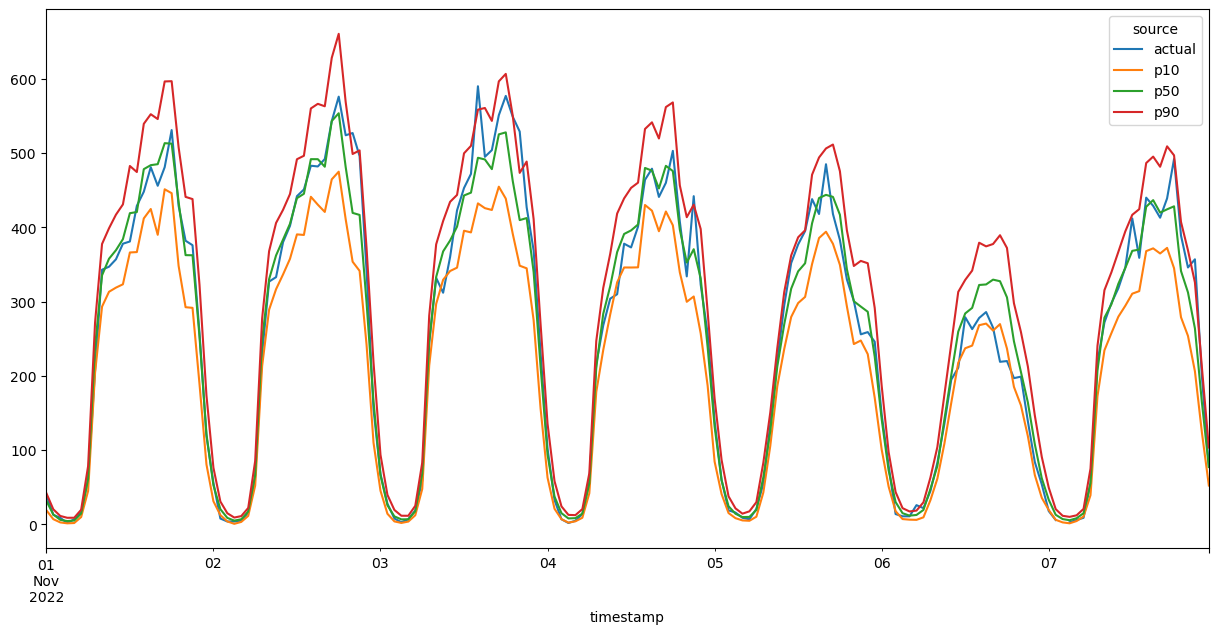

In [58]:
import dateutil
#from dateutil.parser import parse
actuals = df_test_237

results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])

for index, row in actuals.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = pd.concat([results_df, pd.Series({'timestamp' : clean_timestamp , 'value' : row['target_value'], 'source': 'actual'}).to_frame().T], ignore_index=True)
for index, row in forecasts_p10_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = pd.concat([results_df, pd.Series({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'}).to_frame().T] , ignore_index=True)
for index, row in forecasts_p50_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = pd.concat([results_df, pd.Series({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'}).to_frame().T] , ignore_index=True)
for index, row in forecasts_p90_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = pd.concat([results_df, pd.Series({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'}).to_frame().T] , ignore_index=True)

pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")

pivot_df.plot(figsize=(15, 7))

In [60]:
forecasts_p50_df

,Timestamp,Value
0,2022-11-01T00:00:00,31.912493
1,2022-11-01T01:00:00,13.389812
2,2022-11-01T02:00:00,6.224420
3,2022-11-01T03:00:00,4.588059
4,2022-11-01T04:00:00,5.304463
...,...,...
163,2022-11-07T19:00:00,341.192673
164,2022-11-07T20:00:00,312.474350
165,2022-11-07T21:00:00,263.981514
166,2022-11-07T22:00:00,164.486671


In [63]:
forecast_df = pd.DataFrame(index=pd.date_range(start="2022-11-01T00:00:00", periods = 24 * 7, freq="1H"))
pid = df_train['item_id'].unique()
for i in pid:
    forecast_response = forecastquery.query_forecast(ForecastArn=forecast_arn, Filters={"item_id": i.astype(str)})
    p50 = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p50'])
    p50['Timestamp'] = pd.to_datetime(p50['Timestamp'])
    p50 = p50.rename(columns={'Value':i})
    p50 = p50.set_index('Timestamp')
    forecast_df = forecast_df.join(p50)

In [64]:
forecast_df

,48,132,142,161,162,170,186,230,236,237
2022-11-01 00:00:00,72.595612,244.459122,49.707058,35.952776,37.921234,33.210051,62.607300,66.772232,13.153723,31.912493
2022-11-01 01:00:00,40.169285,78.936234,17.591928,15.962780,18.025534,16.744948,29.619105,32.244357,5.261465,13.389812
2022-11-01 02:00:00,24.465066,33.286057,7.879318,6.994725,7.947175,9.867323,20.999951,17.401927,3.455608,6.224420
2022-11-01 03:00:00,19.592087,17.958334,4.964889,6.326741,5.771610,5.923562,9.475657,13.053819,3.719874,4.588059
2022-11-01 04:00:00,21.714182,18.339912,5.512718,7.140305,8.560440,6.155192,13.539166,18.189836,6.193851,5.304463
...,...,...,...,...,...,...,...,...,...,...
2022-11-07 19:00:00,174.384392,378.393890,241.310738,377.850983,282.969116,196.392113,212.221771,234.788803,339.157013,341.192673
2022-11-07 20:00:00,176.401108,416.211243,233.764648,312.703949,249.452232,170.700714,197.179443,205.749786,261.200806,312.474350
2022-11-07 21:00:00,160.673370,402.577820,218.278885,230.899826,187.450714,139.142643,170.823318,190.717979,182.180557,263.981514
2022-11-07 22:00:00,148.647636,412.272034,168.659485,173.750168,131.896709,109.307144,139.623661,172.902794,109.313286,164.486671


In [65]:
forecast_df_path_name = f"{my_bucket_name}/nyc-taxi-trip-data-to-fit/forecast_forecasts_holy_weath.csv"
forecast_df.to_csv(forecast_df_path_name)

In [ ]:
forecast.delete_resource_tree(ResourceArn = dataset_group_arn)
forecast.delete_resource_tree(ResourceArn = ts_dataset_arn)